In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Times New Roman + SimSun + WFM Sans SC']
plt.rcParams['mathtext.fontset']='stix'
# Times New Roman + SimSun + WFM Sans SC
# simsum宋体, times new roman -*, simhei黑体, kaiti楷体, 
# dengxian等线, fangsong仿宋, Microsoft Yahei微软雅黑
plt.rcParams['axes.unicode_minus']=False   
plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = [4, 3]
# plt.rcParams['font.size'] = 12
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'

### 1

In [2]:
def GM1_1(x0, m):
    """
    x0: 参考数据列
    m: 期望的预测序列长度
    RETURN: 
        if 通过级比检验 then (预测序列 x0hat，长度为 m, 参数列 u=[a, b])
        else 可容覆盖 (bd_left, bd_right)
    """
    n = len(x0)
    ratio = x0[:-1]/x0[1:]
    bd_left, bd_right = np.exp(-2/(n+1)), np.exp(2/(n+1))
    if not(all(bd_left < ratio) and all(ratio < bd_right)):   # 通过了级比检验
        print("级比检验未通过")
        return (bd_left, bd_right)
    x1 = np.cumsum(x0)
    z1 = 0.5*x1[1:] + 0.5*x1[:-1]
    B = np.vstack([-z1, np.ones(n-1)]).T
    Y = x0[1:]
    ahat, bhat = np.linalg.inv(B.T @ B) @ B.T @ Y

    k = sp.symbols('k', integer=True, nonneg=True)
    x1_kp1 = (x0[0] - bhat/ahat)*sp.exp(-ahat*(k)) + bhat/ahat
    ff_x1_kp1 = sp.lambdify(k, x1_kp1, 'numpy')
    x1hat = np.zeros(m)
    x1hat[0] = x1[0]
    x1hat[1:] = ff_x1_kp1(np.arange(1, m))
    x0hat = np.zeros(m)
    x0hat[0] = x1hat[0]
    for i in range(1, m):
        x0hat[i] = x1hat[i] - x1hat[i-1]
    return x0hat, (ahat, bhat)

def rela_err(x0, x0hat):
    """
    计算相对误差
    x0: 原始数据列
    x0hat: 预测数据列
    RETURN: 与 x0 等长的相对误差列
    """
    diff = x0 - x0hat[:len(x0)]
    delta = np.abs(diff/x0)
    return delta

In [3]:
x0 = np.array([27260, 29547, 32411, 35388])
x0hat = GM1_1(x0, 9)[0]
x0hat[len(x0):], rela_err(x0, x0hat)

(array([38713.39780694, 42358.99982184, 46347.90453824, 50712.44042873,
        55487.9803059 ]),
 array([0.        , 0.00021803, 0.00229983, 0.0001822 ]))

### 2

In [4]:
def GM2_1(x0, m):
    """
    x0: 参考数据列
    m: 期望的预测序列长度
    RETURN: 
        if 通过级比检验 then (预测序列 x0hat，长度为 m, 参数列 u=[a1, a2, b])
        else 可容覆盖 (bd_left, bd_right)
    """
    n = len(x0)
    ratio = x0[:-1]/x0[1:]
    bd_left, bd_right = np.exp(-2/(n+1)), np.exp(2/(n+1))
    if not(all(bd_left < ratio) and all(ratio < bd_right)):   # 通过了级比检验
        print("级比检验未通过")
        return (bd_left, bd_right)

    x1 = np.cumsum(x0)
    ax0 = x0[1:] - x0[:-1]
    z1 = 0.5*x1[1:] + 0.5*x1[:-1]
    B = np.vstack([-x0[1:], -z1, np.ones(n-1)]).T
    Y = ax0
    a1hat, a2hat, bhat = np.linalg.inv(B.T @ B) @ B.T @ Y
    
    x = sp.symbols('x', cls=sp.Function)
    t = sp.symbols('t', real=True)
    eq = sp.Eq(x(t).diff(t, 2) + a1hat*x(t).diff(t) + a2hat*x(t), bhat)
    x1t = sp.dsolve(eq, ics={x(0): x1[0], x(n-1): x1[-1]}).args[1]
    ff_x1_kp1 = sp.lambdify(t, x1t, 'numpy')
    
    x1hat = np.zeros(m)
    x1hat[0] = x1[0]
    x1hat[1:] = ff_x1_kp1(np.arange(1, m))
    x0hat = np.zeros(m)
    x0hat[0] = x1hat[0]
    for i in range(1, m):
        x0hat[i] = x1hat[i] - x1hat[i-1]

    return x0hat, (a1hat, a2hat, bhat)

In [5]:
x0 = np.array([2.874, 3.278, 3.337, 3.390, 3.679])
x0hat = GM2_1(x0, 10)[0]
x0hat, rela_err(x0, x0hat)

(array([   2.874     ,    3.17539088,    3.31597066,    3.47347107,
           3.71916739,    4.58941146,   10.13150761,   50.89810421,
         357.53999482, 2671.31963786]),
 array([0.        , 0.03130235, 0.00630187, 0.02462274, 0.01091802]))

### 3

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor     # 多层感知机回归分析

data = np.loadtxt('../../../hw/15第15章  预测方法习题解答/ti15_3.txt')
x0 = data[:, :-1]
y0 = data[:, -1]
scaler = MinMaxScaler().fit(x0)
b_x0 = scaler.transform(x0)
md = MLPRegressor(solver='lbfgs', activation='relu', hidden_layer_sizes=20).fit(b_x0, y0)

print("模型精度：", md.score(b_x0, y0))   # 模型检验
sample = np.array([[73.39, 3.9635, 0.9880], [75.55, 4.0975, 1.0268]])
b_sample = scaler.transform(sample)     # 同样的 scaler 作用于 sample
print("\n预测值：", md.predict(b_sample))

模型精度： 0.9876027070468619

预测值： [30856.83471447 32298.45066816]


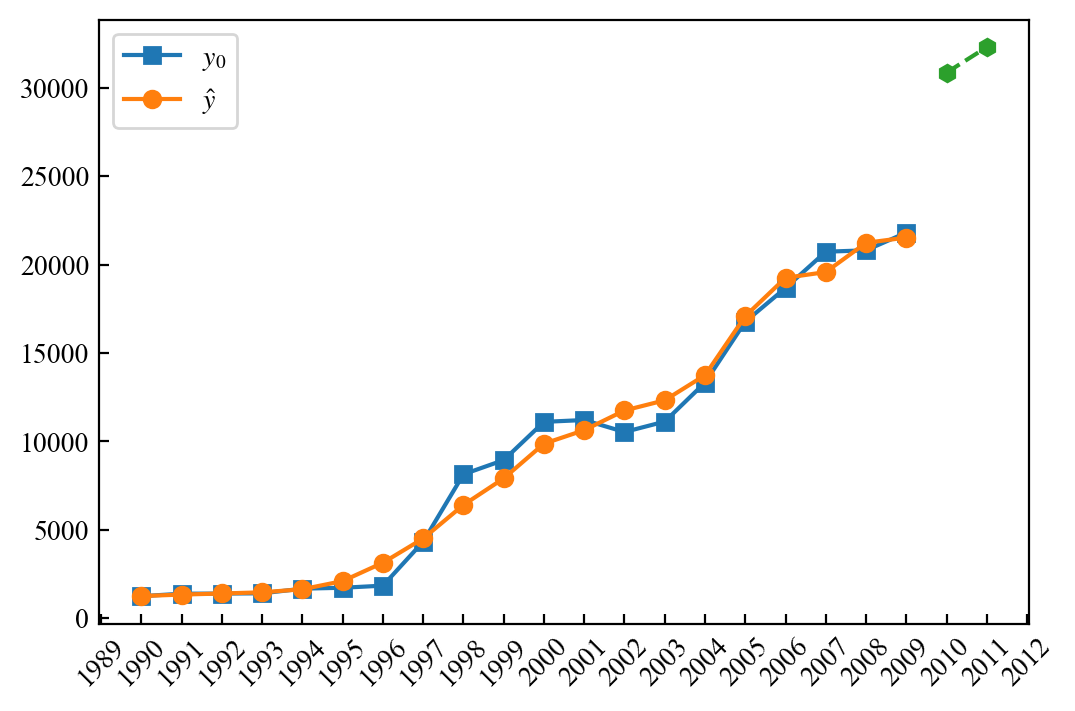

In [7]:
t0 = np.arange(1990, 2010)
yhat = md.predict(b_x0)
tadd = np.arange(2010, 2012)
yadd = md.predict(b_sample)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t0, y0, label="$y_0$", marker='s')
ax.plot(t0, yhat, label='$\hat y$', marker='o')
ax.plot(tadd, yadd, linestyle='--', marker='h')

from matplotlib.ticker import MultipleLocator
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(rotation=45)

ax.legend()
fig.show()